# Testing time cunsumption for different GLM alogrithms  
## 1. Import data
### 1.1. Set parameters

In [55]:
import pandas as pd
import numpy as np
import patsy
import mne
import os
import glob
import re
import matplotlib.pyplot as plt

event = 'Auditory' # or 'Resp'
stat = 'zscore'  # or 'power'
fif_name = f'{event}_{stat}-epo.fif'
task_Tag ='Repeat' #or Yes_No
glm_fea = 'Lexical' #or Phonemic, Acoustic

HOME = os.path.expanduser("~")
LAB_root = os.path.join(HOME, "Box", "CoganLab")
clean_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "clean")
stats_root = os.path.join(LAB_root, 'BIDS-1.0_LexicalDecRepDelay', 'BIDS', "derivatives", "stats")

subjs = [name for name in os.listdir(stats_root) if
         os.path.isdir(os.path.join(stats_root, name)) and name.startswith('D')]
import warnings

subjs = [subj for subj in subjs if
         subj != 'D0107' and subj != 'D0042' and subj != 'D0115']  # actually there is a D0115 rep data, we just skip it because D0115 doesn't have a yes_no
if task_Tag == 'Yes_No':
    subjs = [subj for subj in subjs if subj != 'D0115']

warnings.warn(f"The following subjects are not included: D0107 D0042")

subjs=['D0055','D0063','D0066','D0071',"D0079","D0081",'D0096']
subjs=['D0081']

C:\Users\bl314\AppData\Local\Temp\ipykernel_10064\2466147264.py:30: UserWarning: The following subjects are not included: D0107 D0042
  warnings.warn(f"The following subjects are not included: D0107 D0042")


### 1.2. Loop to import data, and get feature matrix

In [56]:
# Test Multicollinearity
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(X_i):
    """
    Computes the Variance Inflation Factor (VIF) for each feature in the given matrix 
    to detect multicollinearity. Also, plots the correlation matrix as a heatmap.
    
    Parameters:
    X_i : numpy.ndarray
        Feature matrix where each column represents a feature.
    
    Returns:
    pd.DataFrame
        A DataFrame showing the VIF values for each feature.
    """
    
    # Ensure the input is a NumPy array
    if not isinstance(X_i, np.ndarray):
        raise ValueError("Input X_i must be a NumPy array")

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = [f"X{i}" for i in range(X_i.shape[1])]
    vif_data["VIF"] = [variance_inflation_factor(X_i, i) for i in range(X_i.shape[1])]

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(X_i, rowvar=False)  # Compute correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=vif_data["Feature"], yticklabels=vif_data["Feature"],annot_kws={"size": 5})
    plt.title("Feature Correlation Matrix")
    plt.show()

    return vif_data

# Example usage:
# vif_results = check_multicollinearity(X_i)
# print(vif_results)


Now do patent D0081
Reading C:\Users\bl314\Box\CoganLab\BIDS-1.0_LexicalDecRepDelay\BIDS\derivatives\stats\D0081\Auditory_zscore-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2990.00 ms
        0 CTF compensation matrices available
Not setting metadata
324 matching events found
No baseline correction applied


C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


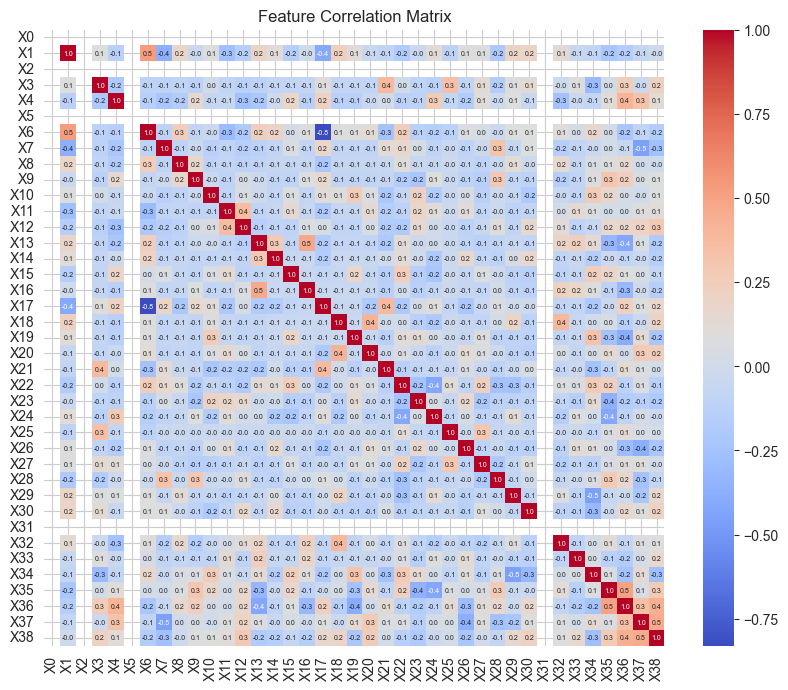

0     458.676711
1       3.665627
2            NaN
3      19.829788
4      39.324866
5            NaN
6      32.232633
7      19.875875
8      13.794872
9       3.740177
10      3.871365
11      8.608039
12     23.452429
13     16.509344
14      2.028158
15      2.568775
16      2.506168
17     33.783515
18      9.139220
19      7.485072
20      3.059615
21      4.684641
22      6.512165
23      4.265281
24      4.838029
25      2.890568
26     11.037236
27      2.692504
28      3.686776
29      4.573543
30      4.205995
31           NaN
32      3.375336
33      2.635780
34      3.267438
35      5.223568
36      9.371049
37      6.889898
38      3.301348
Name: VIF, dtype: float64


In [57]:
# Read dictionaries for acoustic, phonemic, and the other stimulus-based feature matrix
import pandas as pd
phoneme_codes = pd.read_pickle("phoneme_one_hot_dict.pickle")
acoustic_codes = pd.read_pickle("envelope_feature_dict.pickle")

# %% start looping to load patients
data_list = []
filtered_events_list = []
chs = []

for i, subject in enumerate(subjs):
    print(f"Now do patent {subject}")

    #%% Load fif data
    subject_label_chs = 'D' + subject[1:].lstrip('0')
    subject = "sub-"+subject
    subject_No = subject.replace("sub-", "")
    subj_gamma_stats_dir = os.path.join(stats_root, subject_No)
    file_dir = os.path.join(subj_gamma_stats_dir, fif_name)
    epochs=mne.read_epochs(file_dir, False, preload=True)

    #%% Load events
    subj_gamma_clean_dir = os.path.join(clean_root, subject,'ieeg')
    files = glob.glob(os.path.join(subj_gamma_clean_dir, '*acq-*_run-*_desc-clean_events.tsv'))
    files_sorted = sorted(files, key=lambda x: [int(i) for i in re.findall(r'acq-(\d+)_run-(\d+)', x)[0]])
    dfs = [pd.read_csv(f, sep='\t') for f in files_sorted]
    events_df = pd.concat(dfs, ignore_index=True)
    filtered_events_i = events_df[events_df['trial_type'].str.contains(event)
                                & events_df['trial_type'].str.contains('CORRECT')
                                & events_df['trial_type'].str.contains(task_Tag)].reset_index(drop=True)
    trial_split = filtered_events_i['trial_type'].str.split('/', expand=True)
    trial_split.columns = ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']
    filtered_events_i = pd.concat([filtered_events_i, trial_split], axis=1)
    for col in ['Stage', 'RepYesNo', 'Wordness', 'Stim', 'Correctness']:
        filtered_events_i[col] = filtered_events_i[col].astype('category')

    if subject == 'sub-D0102' and task_Tag=='Repeat' and event == 'Auditory':
        filtered_events_i = filtered_events_i[:-1]
        
    # Get data
    if event=='Auditory':
        data_i = epochs[f'Auditory_stim/{task_Tag}/CORRECT'].get_data()
    elif event=='Resp':
        data_i = epochs[f'Resp/{task_Tag}/CORRECT'].get_data()
    if i == 0:
        times = epochs.times
    chs_i = epochs.ch_names
    chs_i = [f"{subject_label_chs}-{ch}" for ch in chs_i]

    # Feature matrix
    wordness_dummy = (filtered_events_i.Wordness == "Word").astype(float)
    phoneme_vectors = []
    acoustic_vectors = []
    for stim in filtered_events_i.Stim:
        phoneme_vectors.append(phoneme_codes[stim])
        acoustic_vectors.append(acoustic_codes[stim])
    X_i = np.column_stack([np.ones(np.shape(data_i)[0]), wordness_dummy,phoneme_vectors,acoustic_vectors])
    
    #Test Multicollinearity
    if i == 0:
        vif_data=check_multicollinearity(X_i)
        print(vif_data['VIF'])
        
    feature_mat_i = np.repeat(X_i[:, np.newaxis, :], np.shape(data_i)[1], axis=1)
    
    # store data
    data_list.append(data_i)
    filtered_events_list.append(feature_mat_i)
    chs.append(chs_i)


### 1.3. Generate a big data matrix (not used now, since permutation is done within single subjects)

In [ ]:
# # Calculate maximum number of trials and total channels
# max_trials = max(d.shape[0] for d in data_list)
# total_channels = sum(d.shape[1] for d in data_list)
# n_times = data_list[0].shape[2]  # Assume n_times is the same for all subjects
# 
# data = np.full((max_trials, total_channels, n_times), np.nan)
# feature_mat = np.full((max_trials, total_channels, 2), np.nan)
# channel_offset = 0
# for i, data_i in enumerate(data_list):
#     n_trials_i, n_channels_i, _ = data_i.shape
#     data[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = data_i
#     feature_mat_i = filtered_events_list[i]
#     feature_mat[:n_trials_i, channel_offset:channel_offset + n_channels_i, :] = feature_mat_i
#     channel_offset += n_channels_i
# 
# print("Data shape:", data.shape)
# print("Feature matrix shape:", feature_mat.shape)
# print("Total channels:", len(chs))

## 2. Compare model speed 
### 2.1. statsmodels OLS

In [ ]:
# import statsmodels.api as sm
# #from mne.stats import fdr_correction
# def sm_glm(x,y):
#     # x: observations (only one feature now)
#     # y: observations
#     # will get beta for one time point of the y: Y(t)=betas(t)X(t)+e
#     # return: beta
#     df = pd.DataFrame({'Y': y, 'X': x})
#     formula = 'Y ~ X'
#     Y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
#     model = sm.OLS(Y, X, missing='drop')
#     results = model.fit()
#     beta = results.params.iloc[1]
#     return beta

In [ ]:
# betas=[]
# for i, data_i in enumerate(data_list):
#     _, n_channels_i, n_times = data_i.shape
#     feature_mat_i = filtered_events_list[i]
#     beta_i = np.full((n_channels_i, n_times), np.nan)
#     for ch in range(n_channels_i):
#         print(f"patient {subjs[i]} chs {ch}")
#         for ti in range(n_times):
#             x = feature_mat_i[:, ch, 1]
#             y = data_i[:, ch, ti]
#             beta_i[ch,ti] = sm_glm(x,y)
#     betas.append(beta_i)
# betas_smols=np.concatenate(betas, axis=0)

### 2.2. Numpy's lstsq

In [58]:
def compute_beta_ch(x, y):
    # x: observations * features
    # y: observations * times
    # will get beta for each time point of the y: Y(t)=betas(t)X(t)+e
    # return: beta: features * times
    mask = ~np.isnan(y[:,0])
    y_clean = y[mask,:]
    x_clean = x[mask,:]
    beta = np.linalg.lstsq(x_clean, y_clean, rcond=None)[0]
    # Get the absolute values since we only care about the weight but not the direction
    beta = np.abs(beta)
    # Average the regressors if it is a multiple regression (intercept + more than one features)
    if beta.shape[0]>2: 
        beta=np.stack((beta[0,:],np.mean(beta[1:,:],axis=0)),axis=0)
    return beta

def compute_beta_loop(feature_mat_i,data_i):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    # return beta_i: beta matrix, channels * features * times
    _, n_channels_i, n_times = data_i.shape
    beta_i = np.full((n_channels_i, 2, n_times), np.nan)
    for ch in range(n_channels_i):
        x = feature_mat_i[:, ch, :]
        y = data_i[:, ch, :]
        beta_i[ch,:,:] = compute_beta_ch(x,y)
    return beta_i

In [48]:
betas=[]
for i, data_i in enumerate(data_list):
    print(f"Patient {subjs[i]}")
    feature_mat_i = filtered_events_list[i]
    compute_beta_loop_i = lambda data: compute_beta_loop(feature_mat_i, data)
    beta_i = compute_beta_loop_i(data_i)
    
    # Get lexical status only
    # beta_i = beta_i[:, 1, :]
    
    # Get phoneme only
    beta_i = np.mean(beta_i[:, 2:34, :],axis=1)
    
    # Get acoustic only
    #beta_i = np.mean(beta_i[:, 34:39, :],axis=1)
  
    betas.append(beta_i)  

betas_lstsq=np.concatenate(betas, axis=0)

Patient D0055


C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bl314\AppData\Local\anaconda3\envs\ieeg\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Patient D0063
Patient D0066
Patient D0071
Patient D0079
Patient D0081
Patient D0096


### 2.3. Compare results (statsmodels OLS is set as standard)

In [49]:
   # Plot GLM
def plot_beta(data_in,title,colbar_lab):
    
    plt.figure(figsize=(10, 5))
    plt.imshow(data_in, aspect='auto', cmap='gray_r', interpolation='nearest')#, vmin=-0.5e-5, vmax=0.5e-5)
    plt.colorbar(label=colbar_lab)
    plt.xlabel("Time points")
    plt.ylabel("Channels")
    plt.title(title)
    
    xticks = np.arange(0, len(times), 20)
    plt.xticks(ticks=xticks, labels=np.round(times[xticks], 2))
    plt.xlabel("Time (s)")
    # 
    # yticks = np.arange(0, len(chs), 5)
    # plt.yticks(ticks=yticks, labels=[chs[i] for i in yticks])
    plt.ylabel("Channels")
    
    zero_time_index = np.argmin(np.abs(times - 0))
    plt.axvline(x=zero_time_index, color='red', linestyle='--', linewidth=1.5, label="Time = 0")
    
    plt.show()

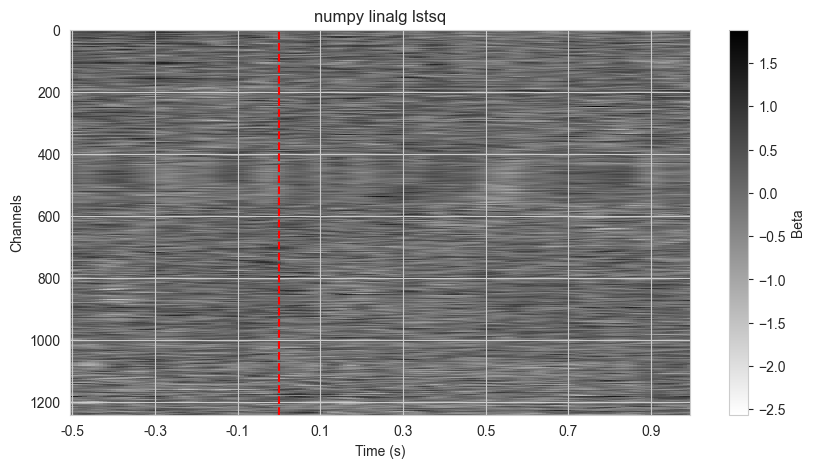

NameError: name 'betas_smols' is not defined

In [8]:
plot_beta(betas_lstsq,'numpy linalg lstsq','Beta')
plot_beta(betas_smols,'numpy statsmodel ols','Beta')

## 3. Try permutation
### 3.1. Used Scipy's permutation_test function
#### 3.1.1. The adjusted stats function

In [22]:
def compute_beta_ch_for_perm(x, y):
    # x: observations (features in nested list)
    # y: observations
    # will get beta for each time point of the y: Y(t)=betas(t)X(t)+e
    # return: R^2
    x = np.array(x.tolist())
    y = y.astype(float)
    mask = ~np.isnan(y)
    y_clean = y[mask]
    x_clean = x[mask,:]
    beta = np.linalg.lstsq(x_clean, y_clean, rcond=None)[0]
    # y_pred = x_clean @ beta 
    # r2 = 1 - np.sum((y_clean - y_pred) ** 2) / (len(y_clean) * np.var(y_clean, ddof=0))
    return beta[1]

#### 3.1.2. Run permutation

In [ ]:
from scipy.stats import permutation_test
ress=[]
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    print(f"Patient {subjs[i]}")
    feature_mat_i = filtered_events_list[i][:,:,0:2]
    feature_mat_i_nested = np.empty(feature_mat_i.shape[:2], dtype=object)
    for m in range(feature_mat_i.shape[0]):
        for j in range(feature_mat_i.shape[1]):
            feature_mat_i_nested[m, j] = list(feature_mat_i[m, j])
    feature_mat_i_expanded = np.repeat(feature_mat_i_nested[:, :, np.newaxis], data_i.shape[2], axis=2)
    print(feature_mat_i_expanded.shape)
    print(data_i.shape)
    res=permutation_test([feature_mat_i_expanded,data_i], compute_beta_ch_for_perm, permutation_type='pairings',n_resamples=10,alternative='two-sided', axis=0)
    ress.append(res)

### 3.2. Baishen's own parallel permutation function
#### 3.2.1. The permutation function

In [59]:
# Baishen's Parallel
from joblib import Parallel, delayed

def permutation_baishen_parallel(feature_mat_i, data_i, n_perms):
    
    n_obs = feature_mat_i.shape[0]
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times    
    def worker(_):
        perm_indices = np.random.permutation(n_obs)
        perm_feature_mat = feature_mat_i[perm_indices, :, :]
        beta_i = compute_beta_loop(perm_feature_mat, data_i)
        return beta_i
    
    results = Parallel(n_jobs=-5)(delayed(worker)(k) for k in range(n_perms))
    null_beta = np.stack(results, axis=0)  # shape: (n_perms, channels, features, times)
    return null_beta

#### 3.2.2. Run permutation and save the null distribution

In [61]:
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    print(f"Patient {subjs[i]}")
    if glm_fea == 'Lexical':
        feature_mat_i = filtered_events_list[i][:,:,0:2]
    elif glm_fea == 'Acoustic':
        feature_mat_i = filtered_events_list[i][:,:,np.r_[0,34:39]]
    elif glm_fea == 'Phonemic':
        feature_mat_i = filtered_events_list[i][:,:,np.r_[0,2:34]]
    n_perms = 30000
    null_beta = permutation_baishen_parallel(feature_mat_i, data_i, n_perms)
    np.save(f'null_beta {subjs[i]} {event} {task_Tag} {glm_fea}.npy', null_beta)
    del null_beta

Patient D0081


#### 3.2.3. Get permutation masks for each patient

In [62]:
#https://ieeg-pipelines.readthedocs.io/en/latest/_modules/ieeg/calc/stats.html#time_perm_cluster
#_perm_gt_1d
def aaron_perm_gt_1d(diff, axis=0):
    m = diff.shape[axis] - 1
    sorted_indices = diff.argsort(axis=axis)  # Get sorted indices
    proportions = np.arange(diff.shape[axis]) / m  # Create proportions array
    # Rearrange to match original order
    return proportions[sorted_indices.argsort(axis=axis)]

In [63]:
# Compute p values upon null distribution
alpha=0.05
for i, _ in enumerate(subjs):    
    print(f"Patient {subjs[i]}")
    # shape: (n_perms, channels, features, times)
    null_beta_i = np.load(f"null_beta {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    # Get the significancy for each permutation that is with **Larger** betas than null distribution
    null_significance_masks=(aaron_perm_gt_1d(null_beta_i[:,:,1,:], axis=0)>(1-alpha)).astype(int)# remove intercept
    np.save(f'null_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy', null_significance_masks)
    del null_significance_masks
    del null_beta_i

Patient D0081


#### 3.2.4. Run time-cluster correction

Patient D0081
run time cluster


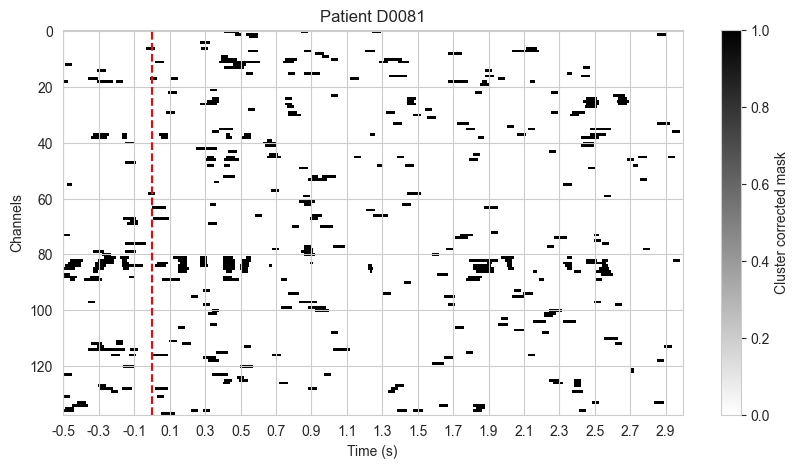

In [64]:
from ieeg.calc.stats import time_cluster
for i, data_i in enumerate(data_list):
    # feature_mat_i: feature matrix, observations * channels * features
    # data_i: eeg data matrix, observations * channels * times
    # beta_i: beta matrix, channels * features * times
    print(f"Patient {subjs[i]}")
    
    # combine original and permute beta
    feature_mat_i = filtered_events_list[i][:,:,0:2]
    beta_i=compute_beta_loop(feature_mat_i,data_i)
    null_beta_i = np.load(f"null_beta {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    beta_i = np.expand_dims(beta_i, axis=0)
    np.save(f"Beta {subjs[i]} {event} {task_Tag} {glm_fea}.npy", beta_i)
    betas_i = np.concatenate([beta_i[:,:,1,:], null_beta_i[:,:,1,:]], axis=0)# also remove intercept
    del beta_i, null_beta_i
    
    # get significance of the original beta against the permutation distribution
    # return: mask_left_i_org channels*times
    org_p_i=aaron_perm_gt_1d(betas_i, axis=0)[0]
    mask_i_org=(org_p_i>(1-alpha)).astype(int)
    del betas_i
    
    # run time cluster correction
    mask_null_i=np.load(f"null_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy")
    mask_time_clus=np.full([mask_i_org.shape[0],mask_i_org.shape[1]],np.nan)
    print('run time cluster')
    # The output p_time_clus tells how **LARGER** the clusters in the real mask are as compared with the clusters in the permuted masks
    # The larger the values, the higher the probabilities are
    for chs in range(mask_i_org.shape[0]):
        mask_time_clus[chs,:]=time_cluster(mask_i_org[chs,:], mask_null_i[:,chs,:],0.05)
    del mask_i_org,mask_null_i
    np.save(f"Time_cluster_mask {subjs[i]} {event} {task_Tag} {glm_fea}.npy", mask_time_clus)
    
    # Plot
    plot_beta(mask_time_clus,f"Patient {subjs[i]}","Cluster corrected mask")


    